In [1]:
import pickle
import numpy as np
from scipy import signal
from useful_func import *
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
fs = 40

In [2]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

duree = model.n_features_in_*100//fs
demi_duree = duree//2
print(demi_duree, 'secondes')

3600 secondes


In [3]:
df = pd.read_csv('info_events.csv', index_col=0)
df = df[  (df['Tag']!='*') & (df['Tag']!= 'S1') ]
df['Picked arrival'] = pd.to_datetime(df['Picked arrival'])
df['file_start'] = pd.to_datetime(df['file_start'])
diff = (df['Picked arrival']- df['file_start'])
df['diff'] = diff.dt.total_seconds()
df['diff'] = df['diff'].astype(int)
df = df.sort_values(by='Picked arrival')

#(df['Tag']!='*') & (df['Tag']!= 'S1')
#(df['Tag']!='*') & (df['Tag']!= 'S1')


In [4]:
all_files = []
for dossier_actuel, sous_dossiers, fichiers in os.walk('data\DonneesB23'):
    if "_MACOSX" not in dossier_actuel:
        for fichier in fichiers:
            if '.DS_Store' not in fichier:
                path = os.path.join(dossier_actuel, fichier)
                y = np.fromfile(path, dtype=np.int32)
                if len(y)/fs > 2*60*60 :
                    all_files.append(path)
del y
noisy_files = []
known_files = list(df['file'].unique())
for file in all_files :
    if file not in known_files :
        noisy_files.append(file)

print(len(noisy_files), 'noisy files')
print(len(known_files), 'known files')
print(len(all_files), 'all files')

105 noisy files
77 known files
181 all files


In [5]:
[round(0.1 +k*.05, 3) for k in range(0, 18)]

[0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95]

In [6]:

seuils = [round(0.1 +k*.05, 3) for k in range(0, 18)]
fn = { seuil : 0 for seuil in seuils}
fp = { seuil : 0 for seuil in seuils}
p  = 0
n  = 0


for i, file in enumerate(all_files) :

    if i%10 == 0 :
        print(i, '/', len(all_files))

    y = np.fromfile(file, dtype=np.int32)
    T = len(y)/fs
    intervalle = 60*60
    nb_echant = int(T/intervalle)
    X_t = []
    for j in range(nb_echant) :
        if len(y[intervalle*j*fs : intervalle*j*fs + (duree)*fs]) == (duree)*fs :
            X_t.append(y[intervalle*j*fs : intervalle*j*fs + (duree)*fs])


    X_t = list(map(get_mov_rms, map(bp, signal.decimate(np.array(X_t), 100))))
    X_t = np.array(X_t)
    predictions = model.predict_proba(X_t)

    known_dates = [ [], list(df[df['file'] == file]['diff'].values) ][file in known_files]

    p += len(known_dates)
    n += nb_echant - 3 * len(known_dates)
    #n += nb_echant - len(known_dates)



    for seuil in seuils :
        indices = np.where(predictions[:,1] > seuil )[0]
        dates = [intervalle*j+ duree//2 for j in indices]

        

        forgot_to_detect = 0
        newly_detected = 0
        
        for date in known_dates :
            if np.all(np.abs(np.array(dates) - date) > demi_duree) :
                forgot_to_detect += 1

        #last_date = np.inf
        for date in dates :
            if np.all(np.abs(np.array(known_dates) - date) > demi_duree) :
                # if date-last_date > 2*intervalle :
                #     newly_detected += 1
                newly_detected += 1
            #last_date = date

        fn[seuil] += forgot_to_detect
        fp[seuil] += newly_detected

print('seuils :', seuils)
print('fn :', fn)
print('fp :', fp)
print('p :', p)
print('n :', n)

0 / 181
10 / 181
20 / 181
30 / 181
40 / 181
50 / 181
60 / 181
70 / 181
80 / 181
90 / 181
100 / 181
110 / 181
120 / 181
130 / 181
140 / 181
150 / 181
160 / 181
170 / 181
180 / 181
seuils : [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
fn : {0.1: 9, 0.15: 9, 0.2: 10, 0.25: 10, 0.3: 11, 0.35: 14, 0.4: 16, 0.45: 17, 0.5: 20, 0.55: 23, 0.6: 24, 0.65: 28, 0.7: 32, 0.75: 35, 0.8: 37, 0.85: 40, 0.9: 49, 0.95: 64}
fp : {0.1: 1167, 0.15: 859, 0.2: 518, 0.25: 366, 0.3: 265, 0.35: 208, 0.4: 149, 0.45: 127, 0.5: 103, 0.55: 85, 0.6: 63, 0.65: 46, 0.7: 32, 0.75: 27, 0.8: 21, 0.85: 14, 0.9: 13, 0.95: 8}
p : 132
n : 6473


In [7]:
fp = np.array([fp[seuil] for seuil in seuils])
fn = np.array([fn[seuil] for seuil in seuils])
tp = p - fn
tn = n - fp

In [8]:
fpr = fp/n
tpr = tp/p
precision = tp/(tp+fp)
accuracy = (tn+tp)/(n+p)

seuils : [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
fpr : [0.18028735 0.13270508 0.08002472 0.05654256 0.04093929 0.03213348
 0.02301869 0.01961996 0.01591225 0.01313147 0.00973274 0.00710644
 0.00494361 0.00417117 0.00324425 0.00216283 0.00200834 0.0012359 ]
tpr : [0.93181818 0.93181818 0.92424242 0.92424242 0.91666667 0.89393939
 0.87878788 0.87121212 0.84848485 0.82575758 0.81818182 0.78787879
 0.75757576 0.73484848 0.71969697 0.6969697  0.62878788 0.51515152]


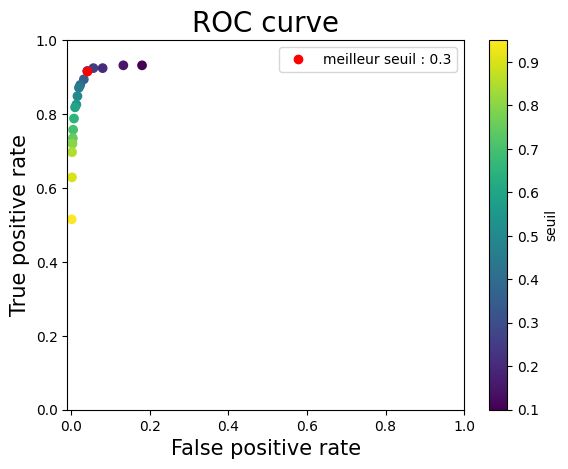

In [23]:
print('seuils :', seuils)
print('fpr :', fpr)
print('tpr :', tpr)
plt.scatter(fpr, tpr, c=seuils, cmap = 'viridis')
plt.colorbar(label = 'seuil')
plt.xlim(-0.01,1)
plt.ylim(0,1)
plt.xlabel('False positive rate', fontsize = 15)
plt.ylabel('True positive rate', fontsize = 15)
plt.title('ROC curve', fontsize = 20)
#print best candidate in red
best = np.argmin(np.array(fpr)**2+(1-np.array(tpr))**2)
plt.plot(fpr[best], tpr[best], 'ro', label = f'meilleur seuil : {seuils[best]}')
plt.legend()

$FPR$, False positive rate : probabilité de fausse alarme
$$
FPR = \frac{FP}{FP + TN} = \frac{FP}{N}
$$

$TPR$, True positive rate : probabilité de bonne alarme
$$
TPR = \frac{TP}{TP + FN}  = \frac{TP}{P}
$$

Precision : probabilité de bonne alarme
$$
Precision = \frac{TP}{TP + FP} 
$$

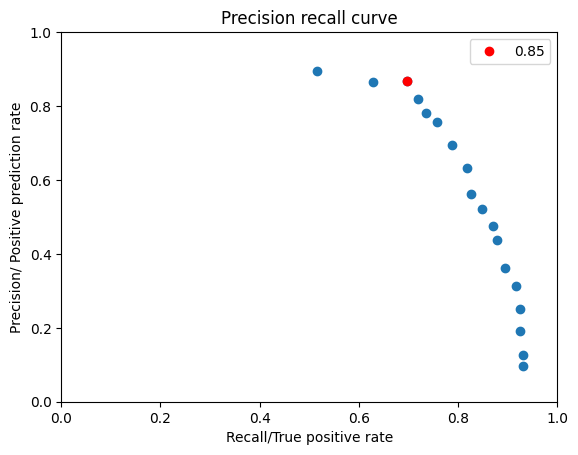

best seuil : 0.85
seuils : [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
fpr : [0.18028735 0.13270508 0.08002472 0.05654256 0.04093929 0.03213348
 0.02301869 0.01961996 0.01591225 0.01313147 0.00973274 0.00710644
 0.00494361 0.00417117 0.00324425 0.00216283 0.00200834 0.0012359 ]
tpr : [0.93181818 0.93181818 0.92424242 0.92424242 0.91666667 0.89393939
 0.87878788 0.87121212 0.84848485 0.82575758 0.81818182 0.78787879
 0.75757576 0.73484848 0.71969697 0.6969697  0.62878788 0.51515152]


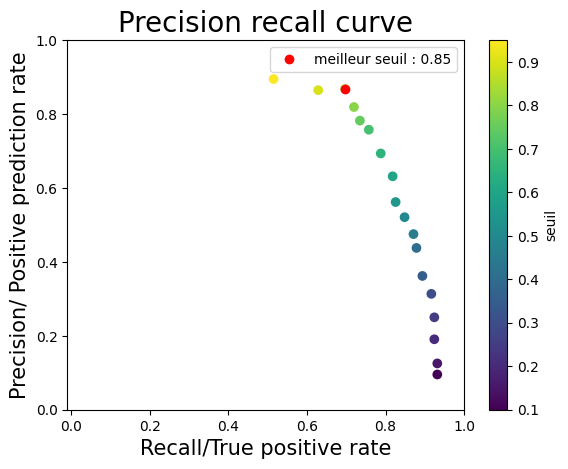

In [26]:
#precision recall/true positive rate curve
plt.figure()
plt.plot(tpr, precision, 'o')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Recall/True positive rate')
plt.ylabel('Precision/ Positive prediction rate')
plt.title('Precision recall curve')
#print best candidate in red
best = np.argmin((1-np.array(tpr))**2+(1-np.array(precision))**2)
plt.plot(tpr[best], precision[best], 'ro', label = seuils[best])
plt.legend()
plt.show()
print('best seuil :', seuils[best])

print('seuils :', seuils)
print('fpr :', fpr)
print('tpr :', tpr)
plt.scatter(tpr, precision, c=seuils, cmap = 'viridis')
plt.colorbar(label = 'seuil')
plt.xlim(-0.01,1)
plt.ylim(0,1)
plt.xlabel('Recall/True positive rate', fontsize = 15)
plt.ylabel('Precision/ Positive prediction rate', fontsize = 15)
plt.title('Precision recall curve', fontsize = 20)
best = np.argmin((1-np.array(tpr))**2+(1-np.array(precision))**2)
plt.plot(tpr[best], precision[best], 'ro', label = f'meilleur seuil : {seuils[best]}')
plt.legend()


Text(0, 0.5, 'taux')

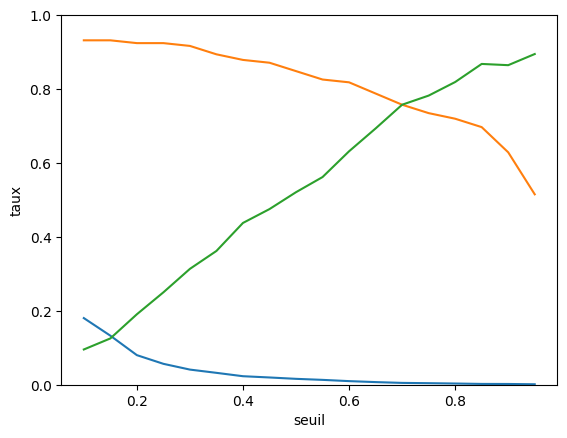

In [29]:
plt.plot(seuils, fpr,  label = 'False positive rate')
plt.plot(seuils, tpr, label = 'True positive rate')
plt.plot(seuils, precision, label = 'Precision')
plt.ylim(0,1)
#plt.legend()
plt.xlabel('seuil')
plt.ylabel('taux')

Text(0.5, 1.0, 'True positive rate')

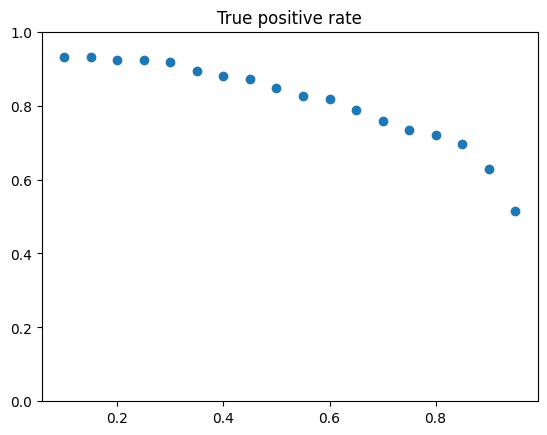

In [14]:
plt.plot(seuils, tp/p, 'o')
plt.ylim(0,1)
plt.title('True positive rate')

Text(0.5, 1.0, 'Precision')

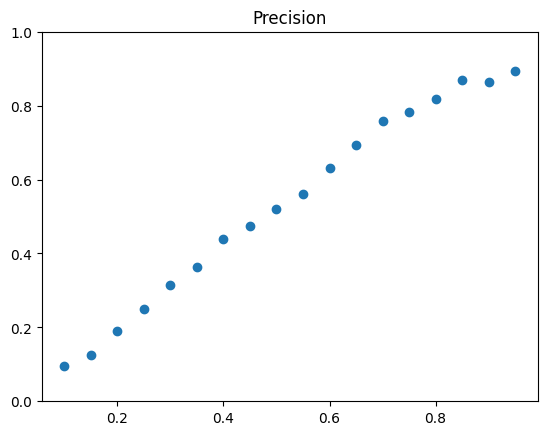

In [15]:
plt.plot(seuils, tp/(tp+fp), 'o')
plt.ylim(0,1)
plt.title('Precision')

In [30]:
import seaborn as sns

In [33]:
tn[best]

6459

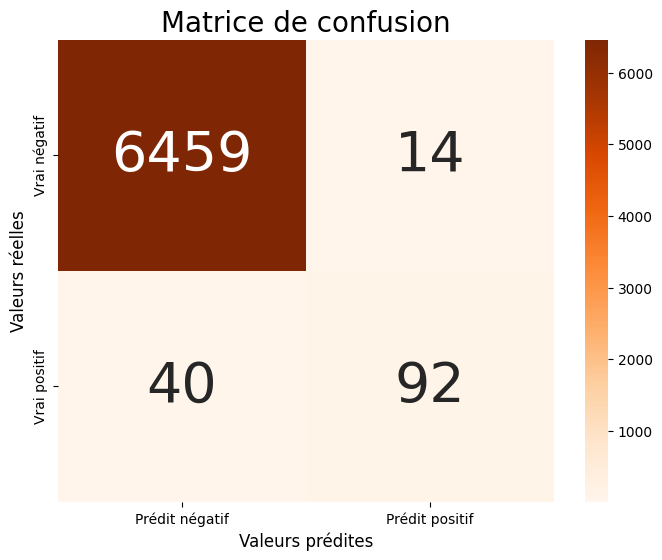

In [37]:
conf_matrix = np.array([[tn[best], fp[best]],
                        [fn[best], tp[best]]])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Oranges',
            xticklabels=['Prédit négatif', 'Prédit positif'],
            yticklabels=['Vrai négatif', 'Vrai positif'],
            annot_kws={"fontsize": 40})  # Augmentation de la taille de la police
plt.xlabel('Valeurs prédites', fontsize=12)  # Augmentation de la taille de la police
plt.ylabel('Valeurs réelles', fontsize=12)  # Augmentation de la taille de la police
plt.title('Matrice de confusion', fontsize=20)  # Augmentation de la taille de la police pour le titre
plt.show()

In [40]:
print('accuracy :', accuracy[best])
print('precision :', precision[best])   
print('recall :', tpr[best])
print('f1 score :', 2*precision[best]*tpr[best]/(precision[best]+tpr[best]))
#kappa
p0 = (tp[best]+tn[best])/(p+n)
pe = (p/n)*(tp[best]+fp[best])+(n/p)*(fn[best]+tn[best])/(p+n)
kappa = (p0-pe)/(1-pe)
print('kappa :', kappa)


accuracy : 0.9918243754731264
precision : 0.8679245283018868
recall : 0.696969696969697
f1 score : 0.7731092436974791
kappa : 1.0001654566349603
